In [1]:
"""
this script displays some of the working principles of the cell_tracker package and track a synthetic cell
"""

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter


import matplotlib.pyplot as plt

from cell_tracker import track_cells, label_local_maximas, get_new_labels

In [2]:
# setup the synthetic cell data

N = 100 # number of gridpoints in x direction
M = 100 # number of gridpoints in y direction

timesteps = 16
timestep = 5 # minutes
start_day = pd.to_datetime("20210715", format="%Y%m%d")

datelist = pd.date_range(start_day, periods=timesteps, freq=str(timestep)+"min")

field_static = {}
field_static["lat"] = np.linspace(0, 10, N).repeat(M).reshape(N, M)
field_static["lon"] = np.linspace(0, 10, M).repeat(N).reshape(M, N).T

In [3]:
def add_synthetic_cell(
    fields, time_range, x_0, y_0, v_x, v_y, cell_size_x=10, cell_size_y=10, intensity=20
):
    cell_size_x = cell_size_x // 2 * 2
    cell_size_y = cell_size_y // 2 * 2
    # create a gaussian cell
    cell = np.ones((cell_size_x, cell_size_y)) * intensity

    for i in range(time_range[0], time_range[1]):
        # get the current position
        x = int(x_0 + v_x * (i - time_range[0]))
        y = int(y_0 + v_y * (i - time_range[0]))

        # add the cell to the field
        fields[
            i,
            x - cell_size_x // 2 : x + cell_size_x // 2,
            y - cell_size_y // 2 : y + cell_size_y // 2,
        ] = np.max(
            (
                cell,
                fields[
                    i,
                    x - cell_size_x // 2 : x + cell_size_x // 2,
                    y - cell_size_y // 2 : y + cell_size_y // 2,
                ],
            )
        )


# create a field with moving cells
fields = np.zeros((timesteps, N, M))

# add cells
add_synthetic_cell(fields, (0, 16), 15, 10, 2, 5, cell_size_x=20)
add_synthetic_cell(fields,(3,15),75,40,-2,3,cell_size_x=20)
add_synthetic_cell(fields,(1,16),17,10,4,1)
add_synthetic_cell(fields,(4,16),20,20,-1,4,cell_size_y=14)
add_synthetic_cell(fields,(11,16),20,45,2,4,cell_size_y=15)

# add gaussian filter
for i, field in enumerate(fields):
    fields[i, :, :] = gaussian_filter(field, sigma=3)

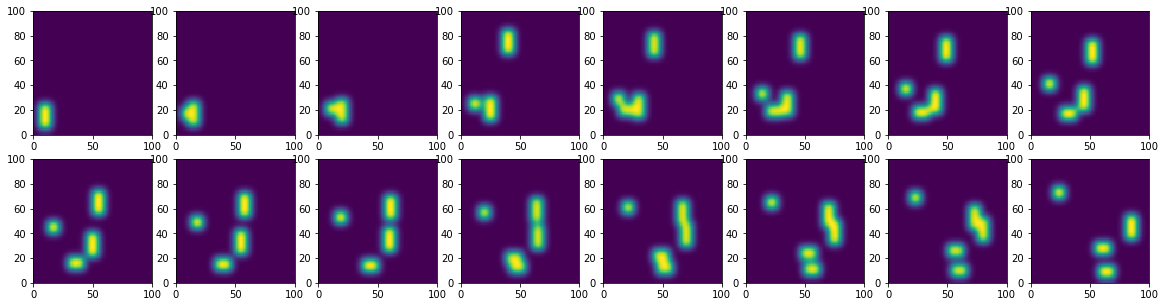

In [4]:
fig,ax = plt.subplots(2,len(fields)//2,figsize=(20,5))
ax = ax.flatten()
for i,field in enumerate(fields):
    ax[i].pcolormesh(field)

In [5]:
# track the cells
kwargs = {'prominence': 5, 'threshold': 10, 'min_distance':5,'fill_method': 'watershed', 'aura':5}
cells = track_cells(fields, datelist, field_static,min_lifespan=40,dynamic_tracking=4, **kwargs)
cell = cells[0]
print(len(cells))

4


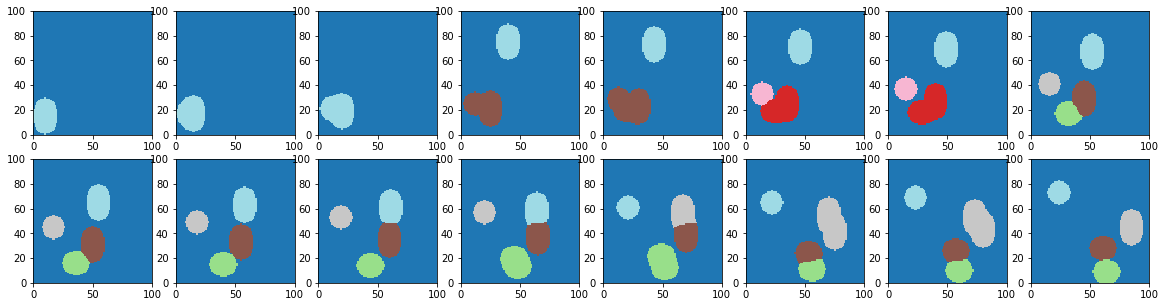

In [11]:
def plt_labels(ax,field,**kwargs):
    labeled = label_local_maximas(field,**kwargs)
    new_cell_labels = get_new_labels(labeled, 5)

    for i in range(M):
        for j in range(N):
            if labeled[i,j] not in new_cell_labels:
                labeled[i,j] = 0
    ax.pcolormesh(labeled, cmap='tab20')

fig,ax = plt.subplots(2,len(fields)//2,figsize=(20,5))
ax = ax.flatten()
for i,field in enumerate(fields):
    plt_labels(ax[i],field,**kwargs)

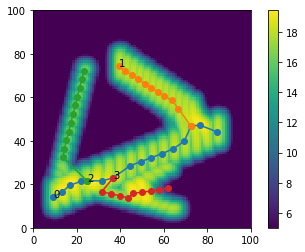

In [7]:
plt.pcolormesh(fields[:, :, :].max(axis=0),vmin=5)
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
for cell in cells:
    plt.plot(cell.mass_center_y, cell.mass_center_x, "o-")
    plt.text(cell.mass_center_y[0], cell.mass_center_x[0], str(cell.cell_id))

In [8]:
print(cells[0].child)
print(cells[3].parent)

[2, 3]
0


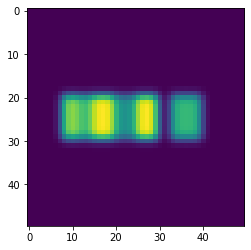

In [9]:
# setup synthetic data to showcase the segmentation

size = 50
field = np.zeros((size, size))

field[8:12, 20:30] = 25
field[12:20, 20:30] = 20
field[15:20, 20:30] = 30
field[20:25, 20:30] = 15
field[25:30, 20:30] = 30
field[33:40, 20:30] = 20
# field[20:25, 40:45] = 30
field = field.T
field = gaussian_filter(field, sigma=1)

# add some noise
plt.imshow(field)

In [10]:
# show the labeled cell masks

# kwargs = {'prominence': 5, 'threshold': 10, 'min_distance': 5,'fill_method': 'watershed', 'aura':0}
labeled, above_threshold = label_local_maximas(field,**kwargs)
new_cell_labels = get_new_labels(labeled, 5)

for i in range(size):
    for j in range(size):
        if labeled[i,j] not in new_cell_labels:
            labeled[i,j] = 0
plt.imshow(labeled, cmap='tab20')


ValueError: too many values to unpack (expected 2)

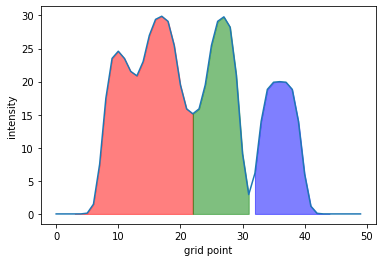

In [ ]:
# visualization (crosssection) of the watershed segmentation
plt.plot(field[25,:])
plt.ylabel('intensity')
plt.xlabel('grid point')
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']

masks = []
for label in new_cell_labels:
    masks.append(labeled[25,:]==label)
masks[1][22] = True

for i,label in enumerate(new_cell_labels):
    plt.fill_between(np.arange(size), field[25,:], 0, where=masks[i], color=colors[i], alpha=0.5)